## Introduction 
[Data wrangling](https://en.wikipedia.org/wiki/Data_wrangling)  is the process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics (Wikipedia)

The purpose of data wrangling notebook  is to transform complex data into easier format so we can focus on the analysis of data, rather than the wrangling in the next notebooks. 

#### Data wrangling steps:
 - **Discovering**  - understanding the data
 - **Structuring** -  organizing the data
     - Naming or renaming variables
     - Changing the type of variables
     - Creating new variables through functions of existing of variables
     - Conditional processing of variables (i.e the values of new variable is based on the values of existing variables) 
 - **Cleaning** 
     - Redesign the data into a usable/functional format and correct/remove any bad data
     - Imputing missing values in a variables
 - **Publishing**
    - Selecting columns from input dataset to output dataset


### Step1. Discovering  the data
#### Load python modules

In [1]:
try:
    import urllib.request
except ImportError:
    !pip install  --user urllib

try:
    import ast
except ImportError:
    !pip install  --user ast
    
try:
    import pandas as pd
except ImportError:
    !pip install  --user pandas

try:    
    import matplotlib.pyplot as plt
except ImportError:
    !pip install --user matplotlib
%matplotlib inline

#### Download the twitter data from object store and display first 5 rows

In [2]:
target_url="https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/geeky-summit/tweets.txt"
file_name="tweets.txt"
urllib.request.urlretrieve(target_url, file_name)
tweets = []
with open(file_name, 'r') as f:
    for lines in f.readlines():
        tweets.append(ast.literal_eval(lines))
frame  = pd.DataFrame(tweets)
frame.head()

,coordinates,created_at,extended_tweet,hashtags,lang,name,screen_name,text,user_location,user_mentions
0,None,Fri Nov 02 21:01:56 +0000 2018,@Symin16 I’d like to know who,[],en,♠,jessmayumba85,@Symin16 I’d like to know who,Toronto ✈ Calgary,"[{'indices': [0, 8], 'id': 1031043960968364034..."
1,None,Fri Nov 02 21:02:01 +0000 2018,@TwoCanSamAdams Legit. There are still chunks ...,[],en,hannahrae cuddleslug,thimblewad,@TwoCanSamAdams Legit. There are still chunks ...,YYC,"[{'indices': [0, 15], 'id': 406677625, 'screen..."
2,"{'type': 'Point', 'coordinates': [-114.007914,...",Fri Nov 02 21:02:05 +0000 2018,Can you recommend anyone for this #job in #Cal...,"[{'indices': [34, 38], 'text': 'job'}, {'indic...",en,TMJ - CAL Manuf Jobs,tmj_cal_manuf,Can you recommend anyone for this #job in #Cal...,Calgary,[]
3,None,Fri Nov 02 21:02:10 +0000 2018,Kids See Ghosts: https://t.co/J4phIy2CQy love ...,[],en,Sunny Rai,TheSunsRay,Kids See Ghosts: https://t.co/J4phIy2CQy love ...,🌎📱,[]
4,"{'type': 'Point', 'coordinates': [-114.0740046...",Fri Nov 02 21:02:13 +0000 2018,"See our latest #Calgary, AB #job and click to ...","[{'indices': [15, 23], 'text': 'Calgary'}, {'i...",en,TMJ-CAL Retail Jobs,tmj_cal_retail,"See our latest #Calgary, AB #job and click to ...",Calgary,[]


#### Understanding the input data

In [3]:
print("Number of rows/columns:",frame.shape, "\n")
for column in frame.columns:
    if column=="user_mentions":
        rownum=1
    else :
        rownum=2
    print("Column name: {colname} \n Column type: {coltype} \n Column data(example): {coldata} \n\n"
          .format(colname=column, coltype=type(frame[column].iloc[rownum]),coldata=frame[column].iloc[rownum]))

Number of rows/columns: (14793, 10) 

Column name: coordinates 
 Column type: <class 'dict'> 
 Column data(example): {'type': 'Point', 'coordinates': [-114.007914, 51.004583]} 


Column name: created_at 
 Column type: <class 'str'> 
 Column data(example): Fri Nov 02 21:02:05 +0000 2018 


Column name: extended_tweet 
 Column type: <class 'str'> 
 Column data(example): Can you recommend anyone for this #job in #Calgary, AB? https://t.co/20JiTB3cRi #SupplyChain #Hiring #CareerArc 


Column name: hashtags 
 Column type: <class 'list'> 
 Column data(example): [{'indices': [34, 38], 'text': 'job'}, {'indices': [42, 50], 'text': 'Calgary'}, {'indices': [80, 92], 'text': 'SupplyChain'}, {'indices': [93, 100], 'text': 'Hiring'}, {'indices': [101, 111], 'text': 'CareerArc'}] 


Column name: lang 
 Column type: <class 'str'> 
 Column data(example): en 


Column name: name 
 Column type: <class 'str'> 
 Column data(example): TMJ - CAL Manuf Jobs 


Column name: screen_name 
 Column type: <class '

#### Columns `text` and `extended_tweet`  look the same. Lets take a closer look.  
#### Plotting lenght distribution for both columns

Text(0.5,1,'extended_tweet')

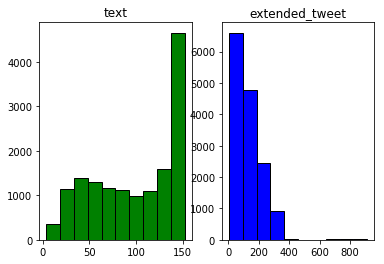

In [4]:
plt.subplot(1, 2, 1)
plt.hist(frame["text"].apply(len).values, color = 'green' ,edgecolor = 'black')
plt.title('text')
plt.subplot(1, 2, 2)
plt.hist(frame["extended_tweet"].apply(len).values, color = 'blue', edgecolor = 'black')
plt.title('extended_tweet')

#### Diplaying the maximimum lenght for extended_tweet  column and printing the columns data for this row:

In [5]:
print("Maximum length for extended_tweet column: ",max(frame["extended_tweet"].apply(len)), "\n")

print(frame["extended_tweet"][frame["extended_tweet"].apply(len).idxmax(axis=1)], "\n")
print(frame["text"][frame["extended_tweet"].apply(len).idxmax(axis=1)])

Maximum length for extended_tweet column:  913 

@erikwilson1975 @Plasticdoe @Vbalance03 @mcfunny @mimetic_ @BeckyJohnson222 @doritmi @EmmaGPaley @jkellyca @jpsportsminer @WendyOrent @ChrisJohnsonMD @Siubhan_H @amanda_pompili @MsTrixter @BlueLionBlog @Rosewind2007 @TinFoilAwards @jjfox123 @Awithonelison @seaglass34 @nicolasDenver @DansMonkeyShack @what_if_007 @StopVaxxedLies @regina1775 @GretchenScience @astrahlgems @Gattinov @jandtee @kidoctr @Takethatdoctors @djt10 @saluce65 @Just4TheCause @Microbedoc2 @cantab_biker @chrisvcsefalvay @xanthonejohn @Brian_Kitchener @SueQuez @carlsmythe @EbolaJuggler @PharmaNemesis @sarah_sxlxp @openmitochondro @ShooguhLipz @1002Loola @and_McDowell What is the deal with this flu strain. The original story was on a news service that interviewed a woman who had been sick as hell who had been told all the details by a Dr. Don't you "flushot doesn't work"ers think that some details could be wrong. SHE says get the shot. 

@erikwilson1975 @Plasticdoe @Vbalan

####  It appears that text column is the truncated version of extended_tweet column.

#### So we have following liist of columns:
 - **coordinates** - user coordinates, can be None or Python type Dict(needs to be split to two columns - longitude and latitude)
 - **created_at**  - creation date, Python type String (needs to be converted to type Date + timezone needs to be changed from UTC to MST)
 - **extended_tweet** - tweet text, Python type String
 - **hashtags** - hashtags, Python type List of Dicts(needs to be converted to String)
 - **lang** - language , Python type String
 - **name** - twitter account name, Python type String
 - **screen_name** - screen name, Python type String
 - **text** - truncated tweet text, Python type String
 - **user_location** - location, Python type String
 - **user_mentions** - user mentions, Python type List of Dicts(needs to be converted to String)

### Step2. Structuring  the data
#### Convert column "created_at"  from String to Date and change timezone from UTC to MST

In [6]:
print(frame["created_at"].iloc[2])
frame["created_at_date"]= pd.to_datetime(frame["created_at"])
frame["created_at_date"]=frame["created_at_date"].dt.tz_localize('UTC').dt.tz_convert('America/Edmonton')
print(frame["created_at_date"].iloc[2])

Fri Nov 02 21:02:05 +0000 2018
2018-11-02 15:02:05-06:00


#### Convert column "coordinates" from Dict to two columns "latitude" and "longitude"

In [7]:
print(frame["coordinates"].head(), "\n")
def convertCoordToList(v):
    if v is None:
        v=[]
    else:
        v= v['coordinates']
    return v
frame['coordinates_list']= frame['coordinates'].map(convertCoordToList)
frame[['latitude','longitude']] = pd.DataFrame(frame['coordinates_list'].values.tolist())
print(frame[['longitude','latitude']].head())

0                                                 None
1                                                 None
2    {'type': 'Point', 'coordinates': [-114.007914,...
3                                                 None
4    {'type': 'Point', 'coordinates': [-114.0740046...
Name: coordinates, dtype: object 

   longitude    latitude
0        NaN         NaN
1        NaN         NaN
2  51.004583 -114.007914
3        NaN         NaN
4  50.997882 -114.074005


#### Convert column "hashtags"  from Dict to Str
For the missing values will impute blank.

In [8]:
print(frame["hashtags"].iloc[2])
def convertHashToString(v):
    if v == []:
        v=' '
    else:
        v=' '.join([d['text'] for d in v])
    return v
frame['hashtags_string']= frame['hashtags'].map(convertHashToString)
print("\n",frame["hashtags_string"].iloc[2])

[{'indices': [34, 38], 'text': 'job'}, {'indices': [42, 50], 'text': 'Calgary'}, {'indices': [80, 92], 'text': 'SupplyChain'}, {'indices': [93, 100], 'text': 'Hiring'}, {'indices': [101, 111], 'text': 'CareerArc'}]

 job Calgary SupplyChain Hiring CareerArc


#### Excersise: convert column "user_mentions" from Dict to Str

In [9]:
print(frame["user_mentions"].iloc[1])
def convertUserToString(v):
    if v == []:
        v=' '
    else:
        v=' '.join([d['screen_name'] for d in v])## type something here (this line will be hidden)
    return v
frame['user_string']= frame['user_mentions'].map(convertUserToString)
print("\n",frame["user_string"].iloc[1])

[{'indices': [0, 15], 'id': 406677625, 'screen_name': 'TwoCanSamAdams', 'id_str': '406677625', 'name': 'TwoCan Jorge'}]

 TwoCanSamAdams


### Step3. Cleaning the data
#### Lets take a look at `extended_tweet` column, we will use it for analysing tweets.

In [10]:
pd.set_option('max_colwidth', 700)
frame['extended_tweet'].head(10)

0                                                                                                                                                                                                                                                                                @Symin16 I’d like to know who
1                                                                                                                                  @TwoCanSamAdams Legit. There are still chunks in the sink and I can’t stand to be in the room, even though it doesn’t smell like puke anymore. I’m just so done with today.
2                                                                                                                                                                                              Can you recommend anyone for this #job in #Calgary, AB? https://t.co/20JiTB3cRi #SupplyChain #Hiring #CareerArc
3                                                                                          

####  Remove URLS 
There are lots of https links which does not have any meaning, let's remove them together with any links starting with www.  (**\S+** means one or more  non-whitespace character)

In [11]:
frame['extended_tweet']=frame['extended_tweet'].str.replace('http\S+|www.\S+', '', case=False)

#### Excersise: remove '/n' (new line symbol) from 'extended_tweet' column

In [12]:
frame['extended_tweet']=frame['extended_tweet'].str.replace('\n',' ') ### this will be hidden

#### Remove user mentions and hashtags from the 'extended_tweet' column and save it as 'extended_tweet_cleaned' column
There are separate columns for user mentions and hashtags. We might need to analyse tweet text without any hashtags/user mentions.

In [13]:
frame['extended_tweet_cleaned']=frame['extended_tweet'].str.replace('[@#]\w+', ' ',case=False)
frame['extended_tweet_cleaned'].head(10)

0                                                                                                                                                                                                                                I’d like to know who
1                                                                                         Legit. There are still chunks in the sink and I can’t stand to be in the room, even though it doesn’t smell like puke anymore. I’m just so done with today.
2                                                                                                                                                                                                Can you recommend anyone for this   in  , AB?       
3                                                                                                                                                                                                                   Kids See Ghosts:  love this track
4               

 We will keep emoji, punctuation,  numbers and special characters for now. They might be useful for analysis. Possibly more cleaning will be applied in the later notebooks
 
 #### Lets take a look a user_location column 
There are 755 unique values, we'll keep it as it is for now. 

In [14]:
print("Number of unique user locations:", len(frame["user_location"].unique()), "\n")
print(frame["user_location"].unique())
#sub="calgary"
#print("\n".join(s for s in frame["user_location"].unique() if sub.lower() in s.lower()))

Number of unique user locations: 755 

['Toronto ✈ Calgary' 'YYC' 'Calgary' '🌎📱' 'Calgary, Alberta' None
 'Calgary, AB' 'Montreal' 'Montréal, Québec' '¯\\_(ツ)_/¯' '524 17 AVE SW'
 'Calgary, Alberta, Canada' 'NYC|MTL' 'calgary , alberta, canada'
 'Traphouse' 'Alberta, Canada' 'Tapioca, Connecticut'
 'Calgary, AB, Canada' 'Calgary, Ab' 'Calgary, Treaty 7, Alberta'
 'Connaught, Calgary' 'Canada' 'Los Angeles, CA' 'Calgary & Treaty 7'
 'Edmonton, AB' 'Calgary | Toronto' '100+ countries' 'Calgary, Canada'
 'https://www.youtube.com/watch?v=PfRAdire3dI' 'Okotoks Alberta'
 'Calgary AB' 'Calgary Alberta' 'Okotoks, Alberta'
 'Vancouver, British Columbia' 'Scary Canadian Security risk to the US'
 'Côte-Nord-du-Golfe-du-Saint-La' 'Calgary Alberta Canada'
 'High River, Alberta' 'Calgary, Alberta ' 'Mesa, AZ' 'Seattle, WA'
 'luncheon kingdom' 'Calgary - Treaty 7' 'Ron Southern School Calgary'
 'Downtown, Calgary' 'Calgary. Alberta. Canada'
 '1104 1 Ave NE, Calgary, AB' 'ÜT: 50.9398707,-113.9842441'


### Step 6. Publishing

#### Lets take a look at the language column

In [15]:
frame["lang"].unique()

array(['en'], dtype=object)

#### Column lang has only one value en so it can be safely ignored

#### Selecting columns from input dataset to output dataset

In [16]:
frame_cleaned=frame[['created_at_date','hashtags_string','user_string','user_location',
                     'longitude','latitude','name', 'screen_name','extended_tweet','extended_tweet_cleaned']]
frame_cleaned.head()

,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned
0,2018-11-02 15:01:56-06:00,,Symin16,Toronto ✈ Calgary,NaN,NaN,♠,jessmayumba85,@Symin16 I’d like to know who,I’d like to know who
1,2018-11-02 15:02:01-06:00,,TwoCanSamAdams,YYC,NaN,NaN,hannahrae cuddleslug,thimblewad,"@TwoCanSamAdams Legit. There are still chunks in the sink and I can’t stand to be in the room, even though it doesn’t smell like puke anymore. I’m just so done with today.","Legit. There are still chunks in the sink and I can’t stand to be in the room, even though it doesn’t smell like puke anymore. I’m just so done with today."
2,2018-11-02 15:02:05-06:00,job Calgary SupplyChain Hiring CareerArc,,Calgary,51.004583,-114.007914,TMJ - CAL Manuf Jobs,tmj_cal_manuf,"Can you recommend anyone for this #job in #Calgary, AB? #SupplyChain #Hiring #CareerArc","Can you recommend anyone for this in , AB?"
3,2018-11-02 15:02:10-06:00,,,🌎📱,NaN,NaN,Sunny Rai,TheSunsRay,Kids See Ghosts: love this track,Kids See Ghosts: love this track
4,2018-11-02 15:02:13-06:00,Calgary job,,Calgary,50.997882,-114.074005,TMJ-CAL Retail Jobs,tmj_cal_retail,"See our latest #Calgary, AB #job and click to apply: barista - Store# 54359, CHINOOK CENTRE FOOD COURT - #Retail #Hiring #CareerArc","See our latest , AB and click to apply: barista - Store# 54359, CHINOOK CENTRE FOOD COURT -"


In [18]:
frame_cleaned.to_csv('tweets_cleaned.csv',index=False)

###  Conclusion
We have  data wrangling and cleaning stage: discovered the data, restructured and reorganized it. 
We have selected columns useful for later ananlysis and saved ned dataset.
More cleaning and wrangling might be needed when data is explored furhter.